# CNN on CIFAR-10

In this notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

The images in CIFAR-10 are RGB images (3 channels) with size 32x32 (so they have size 3x32x32). There are 10 different classes. See examples below.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


## Preliminaries

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics
from math import floor

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(), 
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [3]:
# The output of torchvision datasets are PIL images in the range [0, 1]. 
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
    ]
)

batch_size = 64  # both for training and testing

# Load datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

Files already downloaded and verified
Files already downloaded and verified


In [4]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))

Training data
Number of points: 50000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


### Show example images

Run multiple times to see different examples.

In [5]:
# Get random training images and show them.
images, labels = iter(train_loader).next()
show_image(torchvision.utils.make_grid(images))

AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'next'

## Define a convolutional neural network


**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully, come back and improve the architecture.

In [ ]:
channels = 3
height, width = 32, 32
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""
    
    first = True
    
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x


class Model(nn.Module):
    def __init__(self, num_classes, padding=1, kernelHeight=2, stride=1):
        super().__init__()
        self.first = True
        self.num_classes = num_classes
        activation_fn = nn.ReLU
        outHeight = floor((height + padding*2 - (kernelHeight - 1) - 1)/stride) + 1
        outWidth = floor((width + padding*2 - (kernelHeight - 1)  - 1)/stride) + 1
        n_features = 432
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=1 + kernelHeight*2, stride=stride, padding=padding),
            nn.MaxPool2d((2,2), (2,2)),
            activation_fn(),
            nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=1 + kernelHeight*2, stride=stride, padding=padding),
            nn.MaxPool2d((2,2), (2,2)),
            activation_fn(),
            nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=1 + kernelHeight*2, stride=stride, padding=padding),
            activation_fn(),

            nn.Flatten(),  # from (1, channels, height, width) to (1, channels * height * width)
            nn.Linear(n_features, n_features//2),
            activation_fn(),
            nn.Linear(n_features//2, n_features//4),
            activation_fn(),
            nn.Linear(n_features//4, num_classes),
            # nn.Softmax(num_classes)
        )

    def forward(self, x):
        return self.net(x)


model = Model(n_classes)
device = torch.device('cpu')  # use cuda or cpu
model.to(device)
print(model)

## Define a loss function and optimizer

**Assignment 2:** Define the loss function and optimizer.
You might need to experiment a bit with the learning rate.

In [23]:
loss_fn = nn.CrossEntropyLoss()  # Your code here!
optimizer = optim.Adam(model.parameters(), lr=2e-5)  # Your code here!

## Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 2).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [21]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Output shape: torch.Size([2, 10])
Output logits:
[[ 0.01353349 -0.02094488  0.05661012  0.05378316 -0.07424997  0.03532087
  -0.05554233  0.02393689  0.02697735 -0.0675073 ]
 [ 0.01275428 -0.03610914  0.05362158  0.04895045 -0.06932759  0.03894797
  -0.04953511  0.02889977  0.03261291 -0.06403615]]
Output probabilities:
[[0.10133163 0.09789742 0.10579203 0.10549339 0.09281563 0.10356361
  0.09456834 0.10239132 0.10270311 0.09344357]
 [0.10120792 0.09638143 0.10542969 0.10493837 0.09323239 0.10389396
  0.09509607 0.10285524 0.10323786 0.09372703]]


In [24]:
batch_size = 64
num_epochs = 1
validation_every_steps = 100

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
from tqdm import tqdm
for epoch in tqdm(range(num_epochs)):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass, compute gradients, perform one training step.
        # Your code here!
        output = model.forward(inputs)
        loss = loss_fn(output, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")

  0%|          | 0/40 [00:00<?, ?it/s]

Step 500     training accuracy: 0.1293125
             test accuracy: 0.1774


  2%|▎         | 1/40 [00:38<24:57, 38.39s/it]

Step 1000    training accuracy: 0.2406823394495413
             test accuracy: 0.2509
Step 1500    training accuracy: 0.2595
             test accuracy: 0.2797


  5%|▌         | 2/40 [01:12<22:46, 35.96s/it]

Step 2000    training accuracy: 0.28038990825688076
             test accuracy: 0.3047


  8%|▊         | 3/40 [01:39<19:29, 31.62s/it]

Step 2500    training accuracy: 0.2992086038961039
             test accuracy: 0.3146
Step 3000    training accuracy: 0.3016875
             test accuracy: 0.3193


 10%|█         | 4/40 [02:08<18:31, 30.87s/it]

Step 3500    training accuracy: 0.3136340725806452
             test accuracy: 0.3251


 12%|█▎        | 5/40 [02:35<17:09, 29.42s/it]

Step 4000    training accuracy: 0.31493055555555555
             test accuracy: 0.3294
Step 4500    training accuracy: 0.32284375
             test accuracy: 0.3362


 15%|█▌        | 6/40 [03:06<16:57, 29.92s/it]

Step 5000    training accuracy: 0.3286830357142857
             test accuracy: 0.3413


 18%|█▊        | 7/40 [03:32<15:42, 28.57s/it]

Step 5500    training accuracy: 0.34134615384615385
             test accuracy: 0.3443
Step 6000    training accuracy: 0.34103125
             test accuracy: 0.3448


 20%|██        | 8/40 [04:06<16:11, 30.36s/it]

Step 6500    training accuracy: 0.34893698770491804
             test accuracy: 0.3501
Step 7000    training accuracy: 0.34390625
             test accuracy: 0.3522


 22%|██▎       | 9/40 [04:51<18:02, 34.92s/it]

Step 7500    training accuracy: 0.35135957792207795
             test accuracy: 0.3579


 25%|██▌       | 10/40 [05:57<22:14, 44.47s/it]

Step 8000    training accuracy: 0.3527777777777778
             test accuracy: 0.3575
Step 8500    training accuracy: 0.35903125
             test accuracy: 0.3578


 28%|██▊       | 11/40 [07:02<24:32, 50.76s/it]

Step 9000    training accuracy: 0.3595320351758794
             test accuracy: 0.3688


 30%|███       | 12/40 [07:34<20:58, 44.95s/it]

Step 9500    training accuracy: 0.36584051724137934
             test accuracy: 0.3677
Step 10000   training accuracy: 0.3655
             test accuracy: 0.3712


 32%|███▎      | 13/40 [08:11<19:08, 42.53s/it]

Step 10500   training accuracy: 0.3690587574850299
             test accuracy: 0.3725


 35%|███▌      | 14/40 [09:05<19:58, 46.11s/it]

Step 11000   training accuracy: 0.37349759615384615
             test accuracy: 0.3735
Step 11500   training accuracy: 0.37653125
             test accuracy: 0.3704


 38%|███▊      | 15/40 [09:44<18:20, 44.01s/it]

Step 12000   training accuracy: 0.37216435185185187
             test accuracy: 0.3782
Step 12500   training accuracy: 0.38271875
             test accuracy: 0.3789


 40%|████      | 16/40 [10:15<16:03, 40.15s/it]

Step 13000   training accuracy: 0.38140368852459017
             test accuracy: 0.3819


 42%|████▎     | 17/40 [10:42<13:52, 36.22s/it]

Step 13500   training accuracy: 0.3884253640776699
             test accuracy: 0.3876
Step 14000   training accuracy: 0.38921875
             test accuracy: 0.3869


 45%|████▌     | 18/40 [11:15<12:53, 35.17s/it]

Step 14500   training accuracy: 0.3918042452830189
             test accuracy: 0.3972


 48%|████▊     | 19/40 [11:49<12:13, 34.93s/it]

Step 15000   training accuracy: 0.3912852112676056
             test accuracy: 0.3942
Step 15500   training accuracy: 0.400875
             test accuracy: 0.4021


 50%|█████     | 20/40 [12:29<12:06, 36.32s/it]

Step 16000   training accuracy: 0.40056423611111114
             test accuracy: 0.403


 52%|█████▎    | 21/40 [13:07<11:38, 36.75s/it]

Step 16500   training accuracy: 0.40685096153846156
             test accuracy: 0.405
Step 17000   training accuracy: 0.40909375
             test accuracy: 0.4076


 55%|█████▌    | 22/40 [13:42<10:55, 36.39s/it]

Step 17500   training accuracy: 0.4080447635135135
             test accuracy: 0.4148


 57%|█████▊    | 23/40 [14:14<09:55, 35.05s/it]

Step 18000   training accuracy: 0.4296875
             test accuracy: 0.4154
Step 18500   training accuracy: 0.4170625
             test accuracy: 0.4136


 60%|██████    | 24/40 [15:00<10:14, 38.42s/it]

Step 19000   training accuracy: 0.41412984913793105
             test accuracy: 0.4208
Step 19500   training accuracy: 0.4229375
             test accuracy: 0.4271


 62%|██████▎   | 25/40 [15:48<10:18, 41.23s/it]

Step 20000   training accuracy: 0.42322916666666666
             test accuracy: 0.4274


 65%|██████▌   | 26/40 [16:17<08:42, 37.34s/it]

Step 20500   training accuracy: 0.4226190476190476
             test accuracy: 0.4262
Step 21000   training accuracy: 0.42653125
             test accuracy: 0.4313


 68%|██████▊   | 27/40 [16:44<07:28, 34.51s/it]

Step 21500   training accuracy: 0.43069948186528495
             test accuracy: 0.4295


 70%|███████   | 28/40 [17:20<06:56, 34.73s/it]

Step 22000   training accuracy: 0.43404447115384615
             test accuracy: 0.4333
Step 22500   training accuracy: 0.4321875
             test accuracy: 0.4349


 72%|███████▎  | 29/40 [17:56<06:26, 35.18s/it]

Step 23000   training accuracy: 0.4332298136645963
             test accuracy: 0.4336


 75%|███████▌  | 30/40 [18:29<05:46, 34.67s/it]

Step 23500   training accuracy: 0.437890625
             test accuracy: 0.4384
Step 24000   training accuracy: 0.4404375
             test accuracy: 0.4389


 78%|███████▊  | 31/40 [19:05<05:13, 34.83s/it]

Step 24500   training accuracy: 0.44367732558139533
             test accuracy: 0.4407
Step 25000   training accuracy: 0.4428125
             test accuracy: 0.4409


 80%|████████  | 32/40 [19:39<04:36, 34.58s/it]

Step 25500   training accuracy: 0.4457392331932773
             test accuracy: 0.4413


 82%|████████▎ | 33/40 [20:12<04:00, 34.34s/it]

Step 26000   training accuracy: 0.4529639175257732
             test accuracy: 0.4438
Step 26500   training accuracy: 0.44378125
             test accuracy: 0.4432


 85%|████████▌ | 34/40 [20:46<03:25, 34.22s/it]

Step 27000   training accuracy: 0.44918082524271846
             test accuracy: 0.4477


 88%|████████▊ | 35/40 [21:16<02:44, 32.96s/it]

Step 27500   training accuracy: 0.4580528846153846
             test accuracy: 0.4489
Step 28000   training accuracy: 0.45225
             test accuracy: 0.4497


 90%|█████████ | 36/40 [21:55<02:26, 36.55s/it]


KeyboardInterrupt: 

In [30]:
num_epochs_continue = 10000
for epoch in tqdm(range(num_epochs_continue)):

    train_accuracies_batches = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass, compute gradients, perform one training step.
        # Your code here!
        output = model.forward(inputs)
        loss = loss_fn(output, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Increment step counter
        step += 1

        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))

        if step % validation_every_steps == 0:

            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))

            train_accuracies_batches = []

            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()

            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))

            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")


  0%|          | 0/10000 [00:00<?, ?it/s]

Step 28500   training accuracy: 0.4512841235632184
             test accuracy: 0.453


  0%|          | 1/10000 [00:33<93:44:04, 33.75s/it]

Step 29000   training accuracy: 0.4441287878787879
             test accuracy: 0.451
Step 29500   training accuracy: 0.4591875
             test accuracy: 0.4528


  0%|          | 2/10000 [01:19<113:15:14, 40.78s/it]

Step 30000   training accuracy: 0.4569212147887324
             test accuracy: 0.4527


  0%|          | 3/10000 [01:51<101:57:54, 36.72s/it]

Step 30500   training accuracy: 0.484375
             test accuracy: 0.4514
Step 31000   training accuracy: 0.45990625
             test accuracy: 0.4513


  0%|          | 4/10000 [02:24<98:15:05, 35.38s/it] 

Step 31500   training accuracy: 0.4622869318181818
             test accuracy: 0.4545
Step 32000   training accuracy: 0.46059375
             test accuracy: 0.4559


  0%|          | 5/10000 [02:56<95:08:44, 34.27s/it]

Step 32500   training accuracy: 0.463363299086758
             test accuracy: 0.459


  0%|          | 6/10000 [03:34<98:05:15, 35.33s/it]

Step 33000   training accuracy: 0.46013621794871795
             test accuracy: 0.4563
Step 33500   training accuracy: 0.468
             test accuracy: 0.4526


  0%|          | 7/10000 [04:09<97:33:45, 35.15s/it]

Step 34000   training accuracy: 0.4641544117647059
             test accuracy: 0.4577


  0%|          | 8/10000 [04:41<94:46:55, 34.15s/it]

Step 34500   training accuracy: 0.46484375
             test accuracy: 0.4565
Step 35000   training accuracy: 0.46971875
             test accuracy: 0.4608


  0%|          | 9/10000 [05:16<96:04:44, 34.62s/it]

Step 35500   training accuracy: 0.46975806451612906
             test accuracy: 0.4598


  0%|          | 10/10000 [05:53<97:59:25, 35.31s/it]

Step 36000   training accuracy: 0.484375
             test accuracy: 0.4597
Step 36500   training accuracy: 0.4741875
             test accuracy: 0.4611


  0%|          | 11/10000 [06:36<104:07:47, 37.53s/it]

Step 37000   training accuracy: 0.4730055894308943
             test accuracy: 0.4601
Step 37500   training accuracy: 0.4746875
             test accuracy: 0.4608


  0%|          | 12/10000 [07:21<110:23:53, 39.79s/it]

Step 38000   training accuracy: 0.4742726293103448
             test accuracy: 0.4638


  0%|          | 13/10000 [07:55<105:45:53, 38.12s/it]

Step 38500   training accuracy: 0.48282967032967034
             test accuracy: 0.4657
Step 39000   training accuracy: 0.47534375
             test accuracy: 0.4638


  0%|          | 14/10000 [08:28<101:38:14, 36.64s/it]

Step 39500   training accuracy: 0.4799609375
             test accuracy: 0.466


  0%|          | 15/10000 [08:59<96:58:06, 34.96s/it] 

Step 40000   training accuracy: 0.4830508474576271
             test accuracy: 0.4654
Step 40500   training accuracy: 0.479
             test accuracy: 0.4664


  0%|          | 16/10000 [09:40<102:03:12, 36.80s/it]

Step 41000   training accuracy: 0.47879464285714285
             test accuracy: 0.4659


  0%|          | 17/10000 [10:14<99:31:05, 35.89s/it] 

Step 41500   training accuracy: 0.4855324074074074
             test accuracy: 0.4682
Step 42000   training accuracy: 0.484
             test accuracy: 0.4677


  0%|          | 18/10000 [10:57<105:43:58, 38.13s/it]

Step 42500   training accuracy: 0.486328125
             test accuracy: 0.4664
Step 43000   training accuracy: 0.485125
             test accuracy: 0.4709


  0%|          | 19/10000 [11:35<105:06:01, 37.91s/it]

Step 43500   training accuracy: 0.48635204081632655
             test accuracy: 0.4702


  0%|          | 20/10000 [12:09<101:54:47, 36.76s/it]

Step 44000   training accuracy: 0.4905348557692308
             test accuracy: 0.4707
Step 44500   training accuracy: 0.48753125
             test accuracy: 0.4719


  0%|          | 21/10000 [12:43<99:20:20, 35.84s/it] 

Step 45000   training accuracy: 0.48602552816901406
             test accuracy: 0.4684


  0%|          | 22/10000 [13:16<96:59:25, 34.99s/it]

Step 45500   training accuracy: 0.4892578125
             test accuracy: 0.4733
Step 46000   training accuracy: 0.48790625
             test accuracy: 0.4717


  0%|          | 23/10000 [14:06<109:38:21, 39.56s/it]

Step 46500   training accuracy: 0.4883028314917127
             test accuracy: 0.4673


  0%|          | 24/10000 [14:40<105:26:22, 38.05s/it]

Step 47000   training accuracy: 0.4943359375
             test accuracy: 0.4677
Step 47500   training accuracy: 0.49278125
             test accuracy: 0.4729


  0%|          | 25/10000 [15:31<116:03:23, 41.89s/it]

Step 48000   training accuracy: 0.4899328859060403
             test accuracy: 0.4746


  0%|          | 26/10000 [16:09<112:40:19, 40.67s/it]

Step 48500   training accuracy: 0.5068359375
             test accuracy: 0.4689
Step 49000   training accuracy: 0.493
             test accuracy: 0.4757


  0%|          | 27/10000 [16:43<106:49:29, 38.56s/it]

Step 49500   training accuracy: 0.4957932692307692
             test accuracy: 0.4749
Step 50000   training accuracy: 0.49696875
             test accuracy: 0.4731


  0%|          | 28/10000 [17:20<105:31:16, 38.09s/it]

Step 50500   training accuracy: 0.49688882743362833
             test accuracy: 0.4732


  0%|          | 29/10000 [18:13<118:32:17, 42.80s/it]

Step 51000   training accuracy: 0.49347426470588235
             test accuracy: 0.4752
Step 51500   training accuracy: 0.4965
             test accuracy: 0.4765


  0%|          | 30/10000 [19:07<127:35:37, 46.07s/it]

Step 52000   training accuracy: 0.49838917525773196
             test accuracy: 0.4747


  0%|          | 31/10000 [19:43<118:58:00, 42.96s/it]

Step 52500   training accuracy: 0.5056014150943396
             test accuracy: 0.4744
Step 53000   training accuracy: 0.500125
             test accuracy: 0.4805


  0%|          | 32/10000 [20:27<120:10:21, 43.40s/it]

Step 53500   training accuracy: 0.5028452932098766
             test accuracy: 0.4784


  0%|          | 33/10000 [21:08<118:04:39, 42.65s/it]

Step 54000   training accuracy: 0.5044642857142857
             test accuracy: 0.4804
Step 54500   training accuracy: 0.503
             test accuracy: 0.4824


  0%|          | 34/10000 [21:46<114:18:50, 41.29s/it]

Step 55000   training accuracy: 0.5052283653846154
             test accuracy: 0.484
Step 55500   training accuracy: 0.50134375
             test accuracy: 0.4773


  0%|          | 35/10000 [22:20<107:41:06, 38.90s/it]

Step 56000   training accuracy: 0.5034649581589958
             test accuracy: 0.4766


  0%|          | 36/10000 [22:55<104:24:55, 37.73s/it]

Step 56500   training accuracy: 0.5086894132653061
             test accuracy: 0.4794
Step 57000   training accuracy: 0.50565625
             test accuracy: 0.4817


  0%|          | 37/10000 [23:41<111:30:28, 40.29s/it]

Step 57500   training accuracy: 0.5067557367149759
             test accuracy: 0.4884


  0%|          | 38/10000 [24:08<100:16:29, 36.24s/it]

Step 58000   training accuracy: 0.5035511363636364
             test accuracy: 0.4838
Step 58500   training accuracy: 0.50753125
             test accuracy: 0.4858


  0%|          | 39/10000 [24:34<92:15:10, 33.34s/it] 

Step 59000   training accuracy: 0.5133035714285714
             test accuracy: 0.4832


  0%|          | 40/10000 [25:08<92:13:40, 33.34s/it]

Step 59500   training accuracy: 0.5124080882352942
             test accuracy: 0.4871
Step 60000   training accuracy: 0.5105625
             test accuracy: 0.4829


  0%|          | 41/10000 [25:38<89:27:30, 32.34s/it]

Step 60500   training accuracy: 0.513603583916084
             test accuracy: 0.4816


  0%|          | 42/10000 [26:11<90:40:28, 32.78s/it]

Step 61000   training accuracy: 0.5
             test accuracy: 0.4862
Step 61500   training accuracy: 0.51190625
             test accuracy: 0.4878


  0%|          | 43/10000 [26:46<92:14:20, 33.35s/it]

Step 62000   training accuracy: 0.5211148648648649
             test accuracy: 0.4863
Step 62500   training accuracy: 0.50996875
             test accuracy: 0.4853


  0%|          | 44/10000 [27:21<93:54:27, 33.96s/it]

Step 63000   training accuracy: 0.5141335227272728
             test accuracy: 0.488


  0%|          | 45/10000 [28:08<104:01:21, 37.62s/it]

Step 63500   training accuracy: 0.5148338607594937
             test accuracy: 0.4879
Step 64000   training accuracy: 0.5143125
             test accuracy: 0.4912


  0%|          | 46/10000 [28:53<110:17:29, 39.89s/it]

Step 64500   training accuracy: 0.5188663563829787
             test accuracy: 0.4883


  0%|          | 47/10000 [29:19<99:00:58, 35.81s/it] 

Step 65000   training accuracy: 0.5093085106382979
             test accuracy: 0.49
Step 65500   training accuracy: 0.51859375
             test accuracy: 0.4836


  0%|          | 48/10000 [29:53<97:47:49, 35.38s/it]

Step 66000   training accuracy: 0.5148737980769231
             test accuracy: 0.4912


  0%|          | 49/10000 [30:24<93:54:47, 33.98s/it]

Step 66500   training accuracy: 0.5130208333333334
             test accuracy: 0.4892
Step 67000   training accuracy: 0.51846875
             test accuracy: 0.4843


  0%|          | 50/10000 [30:57<92:46:24, 33.57s/it]

Step 67500   training accuracy: 0.5187121975806451
             test accuracy: 0.4922
Step 68000   training accuracy: 0.52028125
             test accuracy: 0.4942


  1%|          | 51/10000 [31:34<95:52:41, 34.69s/it]

Step 68500   training accuracy: 0.51931330472103
             test accuracy: 0.4934


  1%|          | 52/10000 [32:13<99:18:46, 35.94s/it]

Step 69000   training accuracy: 0.5219938858695652
             test accuracy: 0.4926
Step 69500   training accuracy: 0.52321875
             test accuracy: 0.4939


  1%|          | 53/10000 [32:45<96:03:56, 34.77s/it]

Step 70000   training accuracy: 0.5212997512437811
             test accuracy: 0.4965


  1%|          | 54/10000 [33:11<88:49:20, 32.15s/it]

Step 70500   training accuracy: 0.5236979166666667
             test accuracy: 0.4945
Step 71000   training accuracy: 0.52046875
             test accuracy: 0.4948


  1%|          | 55/10000 [33:45<90:17:14, 32.68s/it]

Step 71500   training accuracy: 0.5284301035502958
             test accuracy: 0.4944


  1%|          | 56/10000 [34:11<84:57:00, 30.75s/it]

Step 72000   training accuracy: 0.5418526785714286
             test accuracy: 0.4934
Step 72500   training accuracy: 0.52071875
             test accuracy: 0.4948


  1%|          | 57/10000 [34:41<83:52:53, 30.37s/it]

Step 73000   training accuracy: 0.5269730839416058
             test accuracy: 0.4994


  1%|          | 58/10000 [35:16<88:18:43, 31.98s/it]

Step 73500   training accuracy: 0.5275
             test accuracy: 0.4916
Step 74000   training accuracy: 0.5292174796747967
             test accuracy: 0.4991


  1%|          | 59/10000 [35:45<85:23:00, 30.92s/it]

Step 74500   training accuracy: 0.5357886904761905
             test accuracy: 0.4991
Step 75000   training accuracy: 0.52628125
             test accuracy: 0.4962


  1%|          | 60/10000 [36:17<86:28:21, 31.32s/it]

Step 75500   training accuracy: 0.5326007593457944
             test accuracy: 0.4912


  1%|          | 61/10000 [36:43<82:05:10, 29.73s/it]

Step 76000   training accuracy: 0.5326412671232876
             test accuracy: 0.4983
Step 76500   training accuracy: 0.52790625
             test accuracy: 0.4996


  1%|          | 62/10000 [37:26<93:14:26, 33.78s/it]

Step 77000   training accuracy: 0.5329241071428571
             test accuracy: 0.4955


  1%|          | 63/10000 [37:55<89:12:42, 32.32s/it]

Step 77500   training accuracy: 0.5432545731707317
             test accuracy: 0.5004
Step 78000   training accuracy: 0.528875
             test accuracy: 0.4995


  1%|          | 64/10000 [38:29<90:14:41, 32.70s/it]

Step 78500   training accuracy: 0.5313020833333333
             test accuracy: 0.4984


  1%|          | 65/10000 [38:57<86:20:03, 31.28s/it]

Step 79000   training accuracy: 0.5442708333333334
             test accuracy: 0.5006
Step 79500   training accuracy: 0.5315
             test accuracy: 0.5021


  1%|          | 66/10000 [39:27<85:43:01, 31.06s/it]

Step 80000   training accuracy: 0.5283368644067796
             test accuracy: 0.5003
Step 80500   training accuracy: 0.53559375
             test accuracy: 0.4994


  1%|          | 67/10000 [39:58<85:02:34, 30.82s/it]

Step 81000   training accuracy: 0.5381332599118943
             test accuracy: 0.4982


  1%|          | 68/10000 [40:25<81:51:26, 29.67s/it]

Step 81500   training accuracy: 0.5453306686046512
             test accuracy: 0.5055
Step 82000   training accuracy: 0.533875
             test accuracy: 0.5


  1%|          | 69/10000 [40:55<82:07:45, 29.77s/it]

Step 82500   training accuracy: 0.5434294871794871
             test accuracy: 0.5049


  1%|          | 70/10000 [41:20<78:35:38, 28.49s/it]

Step 83000   training accuracy: 0.5428240740740741
             test accuracy: 0.4996
Step 83500   training accuracy: 0.538375
             test accuracy: 0.5014


  1%|          | 71/10000 [41:53<82:35:41, 29.95s/it]

Step 84000   training accuracy: 0.5399252300613497
             test accuracy: 0.5055


  1%|          | 72/10000 [42:18<78:15:04, 28.37s/it]

Step 84500   training accuracy: 0.5401278409090909
             test accuracy: 0.5046
Step 85000   training accuracy: 0.53821875
             test accuracy: 0.5025


  1%|          | 73/10000 [42:49<80:08:12, 29.06s/it]

Step 85500   training accuracy: 0.5441913167938931
             test accuracy: 0.5036
Step 86000   training accuracy: 0.54021875
             test accuracy: 0.5088


  1%|          | 74/10000 [43:22<83:42:12, 30.36s/it]

Step 86500   training accuracy: 0.5425130208333333
             test accuracy: 0.5049


  1%|          | 75/10000 [43:56<86:13:04, 31.27s/it]

Step 87000   training accuracy: 0.5404040404040404
             test accuracy: 0.5062
Step 87500   training accuracy: 0.54725
             test accuracy: 0.507


  1%|          | 76/10000 [44:26<85:38:10, 31.07s/it]

Step 88000   training accuracy: 0.5448843149038461
             test accuracy: 0.5085


  1%|          | 77/10000 [44:56<84:27:10, 30.64s/it]

Step 88500   training accuracy: 0.5503731343283582
             test accuracy: 0.5088
Step 89000   training accuracy: 0.54465625
             test accuracy: 0.507


  1%|          | 78/10000 [45:25<82:58:25, 30.11s/it]

Step 89500   training accuracy: 0.5416370738636364
             test accuracy: 0.5113


  1%|          | 79/10000 [45:54<82:24:36, 29.90s/it]

Step 90000   training accuracy: 0.5310267857142857
             test accuracy: 0.5074
Step 90500   training accuracy: 0.5490625
             test accuracy: 0.508


  1%|          | 80/10000 [46:25<83:07:01, 30.16s/it]

Step 91000   training accuracy: 0.5457899305555556
             test accuracy: 0.5043


  1%|          | 81/10000 [46:56<83:30:52, 30.31s/it]

Step 91500   training accuracy: 0.5677083333333334
             test accuracy: 0.51
Step 92000   training accuracy: 0.54896875
             test accuracy: 0.5084


  1%|          | 82/10000 [47:32<88:37:50, 32.17s/it]

Step 92500   training accuracy: 0.5466657366071429
             test accuracy: 0.5063
Step 93000   training accuracy: 0.5505
             test accuracy: 0.5062


  1%|          | 83/10000 [48:08<91:21:23, 33.16s/it]

Step 93500   training accuracy: 0.5476173642533937
             test accuracy: 0.5102


  1%|          | 84/10000 [48:39<89:29:39, 32.49s/it]

Step 94000   training accuracy: 0.54521484375
             test accuracy: 0.5114
Step 94500   training accuracy: 0.55046875
             test accuracy: 0.5083


  1%|          | 85/10000 [49:19<96:30:10, 35.04s/it]

Step 95000   training accuracy: 0.5509259259259259
             test accuracy: 0.513


  1%|          | 86/10000 [49:57<98:14:04, 35.67s/it]

Step 95500   training accuracy: 0.5597330729166666
             test accuracy: 0.5127
Step 96000   training accuracy: 0.55253125
             test accuracy: 0.5083


  1%|          | 87/10000 [50:48<110:56:40, 40.29s/it]

Step 96500   training accuracy: 0.5495123407643312
             test accuracy: 0.5142


  1%|          | 88/10000 [51:29<111:54:42, 40.65s/it]

Step 97000   training accuracy: 0.56591796875
             test accuracy: 0.5139
Step 97500   training accuracy: 0.5509375
             test accuracy: 0.5083


  1%|          | 89/10000 [52:26<125:02:35, 45.42s/it]

Step 98000   training accuracy: 0.5535
             test accuracy: 0.5139
Step 98500   training accuracy: 0.556625
             test accuracy: 0.5156


  1%|          | 90/10000 [53:10<123:53:13, 45.00s/it]

Step 99000   training accuracy: 0.5537526709401709
             test accuracy: 0.5115


  1%|          | 91/10000 [53:38<110:23:59, 40.11s/it]

Step 99500   training accuracy: 0.5590557795698925
             test accuracy: 0.5155
Step 100000   training accuracy: 0.55278125
             test accuracy: 0.5107


  1%|          | 92/10000 [54:13<105:41:53, 38.40s/it]

Step 100500   training accuracy: 0.5587484529702971
             test accuracy: 0.5131


  1%|          | 93/10000 [54:47<102:24:48, 37.21s/it]

Step 101000   training accuracy: 0.5459784836065574
             test accuracy: 0.5191
Step 101500   training accuracy: 0.56046875
             test accuracy: 0.5177


  1%|          | 94/10000 [55:25<103:03:53, 37.46s/it]

Step 102000   training accuracy: 0.5605238970588236
             test accuracy: 0.5136


  1%|          | 95/10000 [55:57<98:06:03, 35.66s/it] 

Step 102500   training accuracy: 0.5600754310344828
             test accuracy: 0.5129


  1%|          | 95/10000 [56:18<97:50:30, 35.56s/it]


KeyboardInterrupt: 

In [35]:
num_epochs_continue = 100
for epoch in tqdm(range(num_epochs_continue)):

    train_accuracies_batches = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass, compute gradients, perform one training step.
        # Your code here!
        output = model.forward(inputs)
        loss = loss_fn(output, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Increment step counter
        step += 1

        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))

        if step % validation_every_steps == 0:

            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))

            train_accuracies_batches = []

            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()

            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))

            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")


  0%|          | 0/100 [00:00<?, ?it/s]

Step 103000   training accuracy: 0.5563902243589743
             test accuracy: 0.5131
Step 103500   training accuracy: 0.5620625
             test accuracy: 0.5178


  1%|          | 1/100 [00:28<46:23, 28.12s/it]

Step 104000   training accuracy: 0.5568599598930482
             test accuracy: 0.5173


  2%|▏         | 2/100 [00:53<43:15, 26.49s/it]

Step 104500   training accuracy: 0.5577445652173914
             test accuracy: 0.5143
Step 105000   training accuracy: 0.5625625
             test accuracy: 0.5157


  3%|▎         | 3/100 [01:30<50:42, 31.37s/it]

Step 105500   training accuracy: 0.5637600806451613
             test accuracy: 0.5185


  4%|▍         | 4/100 [02:06<52:51, 33.04s/it]

Step 106000   training accuracy: 0.5625
             test accuracy: 0.5182
Step 106500   training accuracy: 0.562375
             test accuracy: 0.5189


  5%|▌         | 5/100 [02:40<52:47, 33.35s/it]

Step 107000   training accuracy: 0.5655487804878049
             test accuracy: 0.5161
Step 107500   training accuracy: 0.56459375
             test accuracy: 0.5224


  6%|▌         | 6/100 [03:11<51:10, 32.67s/it]

Step 108000   training accuracy: 0.5666419719827587
             test accuracy: 0.517


  7%|▋         | 7/100 [03:42<49:53, 32.19s/it]

Step 108500   training accuracy: 0.5659340659340659
             test accuracy: 0.5204
Step 109000   training accuracy: 0.56240625
             test accuracy: 0.5158


  8%|▊         | 8/100 [04:26<54:55, 35.82s/it]

Step 109500   training accuracy: 0.5646484375
             test accuracy: 0.5196


  9%|▉         | 9/100 [04:53<50:01, 32.98s/it]

Step 110000   training accuracy: 0.569385593220339
             test accuracy: 0.5213
Step 110500   training accuracy: 0.56425
             test accuracy: 0.5225


 10%|█         | 10/100 [05:28<50:40, 33.79s/it]

Step 111000   training accuracy: 0.5731491815476191
             test accuracy: 0.5154


 11%|█         | 11/100 [06:12<54:35, 36.81s/it]

Step 111500   training accuracy: 0.5598958333333334
             test accuracy: 0.5125
Step 112000   training accuracy: 0.5690625
             test accuracy: 0.5233


 12%|█▏        | 12/100 [07:00<58:54, 40.17s/it]

Step 112500   training accuracy: 0.5724954044117647
             test accuracy: 0.5196
Step 113000   training accuracy: 0.56975
             test accuracy: 0.5218


 13%|█▎        | 13/100 [07:47<1:01:22, 42.33s/it]

Step 113500   training accuracy: 0.5698341836734694
             test accuracy: 0.5185


 14%|█▍        | 14/100 [08:22<57:19, 40.00s/it]  

Step 114000   training accuracy: 0.5748197115384616
             test accuracy: 0.5213
Step 114500   training accuracy: 0.56884375
             test accuracy: 0.524


 15%|█▌        | 15/100 [08:57<54:47, 38.68s/it]

Step 115000   training accuracy: 0.5721097417840375
             test accuracy: 0.5218


 16%|█▌        | 16/100 [09:44<57:42, 41.22s/it]

Step 115500   training accuracy: 0.5720486111111112
             test accuracy: 0.5228
Step 116000   training accuracy: 0.57196875
             test accuracy: 0.5219


 17%|█▋        | 17/100 [10:16<53:14, 38.49s/it]

Step 116500   training accuracy: 0.5754057320441989
             test accuracy: 0.5253


 18%|█▊        | 18/100 [10:48<49:40, 36.35s/it]

Step 117000   training accuracy: 0.575
             test accuracy: 0.526
Step 117500   training accuracy: 0.5725625
             test accuracy: 0.5233


 19%|█▉        | 19/100 [11:26<50:01, 37.05s/it]

Step 118000   training accuracy: 0.5760276845637584
             test accuracy: 0.5281


 20%|██        | 20/100 [11:54<45:43, 34.29s/it]

Step 118500   training accuracy: 0.5537109375
             test accuracy: 0.5263
Step 119000   training accuracy: 0.573875
             test accuracy: 0.5273


 21%|██        | 21/100 [12:29<45:17, 34.40s/it]

Step 119500   training accuracy: 0.5753205128205128
             test accuracy: 0.5233
Step 120000   training accuracy: 0.5794375
             test accuracy: 0.5255


 22%|██▏       | 22/100 [13:03<44:31, 34.25s/it]

Step 120500   training accuracy: 0.577433628318584
             test accuracy: 0.528


 23%|██▎       | 23/100 [13:48<48:06, 37.49s/it]

Step 121000   training accuracy: 0.5797794117647059
             test accuracy: 0.5263
Step 121500   training accuracy: 0.5774375
             test accuracy: 0.5175


 24%|██▍       | 24/100 [14:28<48:29, 38.28s/it]

Step 122000   training accuracy: 0.5767960695876289
             test accuracy: 0.5275


 25%|██▌       | 25/100 [15:01<45:51, 36.69s/it]

Step 122500   training accuracy: 0.5713443396226415
             test accuracy: 0.5297
Step 123000   training accuracy: 0.5806875
             test accuracy: 0.5238


 26%|██▌       | 26/100 [15:38<45:11, 36.64s/it]

Step 123500   training accuracy: 0.5783661265432098
             test accuracy: 0.5282


 27%|██▋       | 27/100 [16:08<42:23, 34.84s/it]

Step 124000   training accuracy: 0.5829613095238095
             test accuracy: 0.5295
Step 124500   training accuracy: 0.57778125
             test accuracy: 0.5266


 28%|██▊       | 28/100 [16:38<40:06, 33.42s/it]

Step 125000   training accuracy: 0.5800480769230769
             test accuracy: 0.5253
Step 125500   training accuracy: 0.5825
             test accuracy: 0.5254


 29%|██▉       | 29/100 [17:08<38:09, 32.24s/it]

Step 126000   training accuracy: 0.5844338389121339
             test accuracy: 0.5244


 30%|███       | 30/100 [17:34<35:19, 30.28s/it]

Step 126500   training accuracy: 0.5842633928571429
             test accuracy: 0.5273
Step 127000   training accuracy: 0.581125
             test accuracy: 0.53


 31%|███       | 31/100 [18:21<40:43, 35.41s/it]

Step 127500   training accuracy: 0.5857110507246377
             test accuracy: 0.531


 32%|███▏      | 32/100 [19:02<42:02, 37.09s/it]

Step 128000   training accuracy: 0.5756392045454546
             test accuracy: 0.5272
Step 128500   training accuracy: 0.5811875
             test accuracy: 0.5258


 33%|███▎      | 33/100 [20:05<50:00, 44.78s/it]

Step 129000   training accuracy: 0.5819196428571428
             test accuracy: 0.5285


 34%|███▍      | 34/100 [20:54<50:45, 46.15s/it]

Step 129500   training accuracy: 0.5916819852941176
             test accuracy: 0.5234
Step 130000   training accuracy: 0.58196875
             test accuracy: 0.5283


 35%|███▌      | 35/100 [21:30<46:40, 43.08s/it]

Step 130500   training accuracy: 0.5847355769230769
             test accuracy: 0.5312


 36%|███▌      | 36/100 [21:55<40:11, 37.68s/it]

Step 131000   training accuracy: 0.625
             test accuracy: 0.5309
Step 131500   training accuracy: 0.5894375
             test accuracy: 0.5296


 37%|███▋      | 37/100 [22:27<37:47, 36.00s/it]

Step 132000   training accuracy: 0.5891751126126126
             test accuracy: 0.5294
Step 132500   training accuracy: 0.58425
             test accuracy: 0.5348


 38%|███▊      | 38/100 [23:06<38:04, 36.85s/it]

Step 133000   training accuracy: 0.5869318181818182
             test accuracy: 0.5295


 39%|███▉      | 39/100 [23:54<40:49, 40.16s/it]

Step 133500   training accuracy: 0.5912776898734177
             test accuracy: 0.5317
Step 134000   training accuracy: 0.58434375
             test accuracy: 0.5293


 40%|████      | 40/100 [24:21<36:18, 36.30s/it]

Step 134500   training accuracy: 0.58984375
             test accuracy: 0.5245


 41%|████      | 41/100 [24:49<33:17, 33.85s/it]

Step 135000   training accuracy: 0.5897606382978723
             test accuracy: 0.5307
Step 135500   training accuracy: 0.5881875
             test accuracy: 0.5307


 42%|████▏     | 42/100 [25:19<31:39, 32.75s/it]

Step 136000   training accuracy: 0.5908453525641025
             test accuracy: 0.5329


 43%|████▎     | 43/100 [25:47<29:33, 31.11s/it]

Step 136500   training accuracy: 0.5802083333333333
             test accuracy: 0.5299
Step 137000   training accuracy: 0.5911875
             test accuracy: 0.5302


 44%|████▍     | 44/100 [26:17<28:44, 30.79s/it]

Step 137500   training accuracy: 0.5885206653225806
             test accuracy: 0.5267
Step 138000   training accuracy: 0.59078125
             test accuracy: 0.5267


 45%|████▌     | 45/100 [26:47<28:09, 30.71s/it]

Step 138500   training accuracy: 0.5937835300429185
             test accuracy: 0.5282


 46%|████▌     | 46/100 [27:16<27:07, 30.14s/it]

Step 139000   training accuracy: 0.5998641304347826
             test accuracy: 0.5322
Step 139500   training accuracy: 0.59228125
             test accuracy: 0.5317


 47%|████▋     | 47/100 [27:58<29:47, 33.73s/it]

Step 140000   training accuracy: 0.5934001865671642
             test accuracy: 0.5324


 48%|████▊     | 48/100 [28:26<27:43, 31.99s/it]

Step 140500   training accuracy: 0.5938802083333333
             test accuracy: 0.5344
Step 141000   training accuracy: 0.5948125
             test accuracy: 0.5339


 49%|████▉     | 49/100 [29:02<28:10, 33.15s/it]

Step 141500   training accuracy: 0.598696375739645
             test accuracy: 0.5322


 50%|█████     | 50/100 [29:33<27:09, 32.59s/it]

Step 142000   training accuracy: 0.5993303571428571
             test accuracy: 0.5326
Step 142500   training accuracy: 0.593875
             test accuracy: 0.5352


 51%|█████     | 51/100 [30:06<26:44, 32.74s/it]

Step 143000   training accuracy: 0.5967723540145985
             test accuracy: 0.5316
Step 143500   training accuracy: 0.5976875
             test accuracy: 0.5374


 52%|█████▏    | 52/100 [30:42<26:51, 33.57s/it]

Step 144000   training accuracy: 0.5991171239837398
             test accuracy: 0.5345


 53%|█████▎    | 53/100 [31:20<27:28, 35.08s/it]

Step 144500   training accuracy: 0.5971726190476191
             test accuracy: 0.5323
Step 145000   training accuracy: 0.596
             test accuracy: 0.5365


 54%|█████▍    | 54/100 [31:53<26:25, 34.46s/it]

Step 145500   training accuracy: 0.5996276285046729
             test accuracy: 0.534


 55%|█████▌    | 55/100 [32:21<24:19, 32.44s/it]

Step 146000   training accuracy: 0.5970676369863014
             test accuracy: 0.5326
Step 146500   training accuracy: 0.5953125
             test accuracy: 0.5326


 56%|█████▌    | 56/100 [32:59<25:01, 34.12s/it]

Step 147000   training accuracy: 0.5998883928571429
             test accuracy: 0.5342


 57%|█████▋    | 57/100 [33:30<23:43, 33.10s/it]

Step 147500   training accuracy: 0.5939405487804879
             test accuracy: 0.5353
Step 148000   training accuracy: 0.60046875
             test accuracy: 0.5307


 58%|█████▊    | 58/100 [34:11<24:50, 35.48s/it]

Step 148500   training accuracy: 0.59859375
             test accuracy: 0.5372


 59%|█████▉    | 59/100 [34:45<24:00, 35.14s/it]

Step 149000   training accuracy: 0.6154513888888888
             test accuracy: 0.5339
Step 149500   training accuracy: 0.600375
             test accuracy: 0.5338


 60%|██████    | 60/100 [35:22<23:47, 35.70s/it]

Step 150000   training accuracy: 0.6042770127118644
             test accuracy: 0.5343
Step 150500   training accuracy: 0.59715625
             test accuracy: 0.5362


 61%|██████    | 61/100 [35:56<22:51, 35.17s/it]

Step 151000   training accuracy: 0.600977422907489
             test accuracy: 0.5346


 62%|██████▏   | 62/100 [36:24<20:56, 33.07s/it]

Step 151500   training accuracy: 0.6043786337209303
             test accuracy: 0.5389
Step 152000   training accuracy: 0.59978125
             test accuracy: 0.5363


 63%|██████▎   | 63/100 [37:00<20:49, 33.77s/it]

Step 152500   training accuracy: 0.5995192307692307
             test accuracy: 0.5384


 64%|██████▍   | 64/100 [37:35<20:36, 34.33s/it]

Step 153000   training accuracy: 0.6032986111111112
             test accuracy: 0.5363
Step 153500   training accuracy: 0.6051875
             test accuracy: 0.5369


 65%|██████▌   | 65/100 [38:12<20:19, 34.85s/it]

Step 154000   training accuracy: 0.5996932515337423
             test accuracy: 0.5379


 66%|██████▌   | 66/100 [38:52<20:44, 36.60s/it]

Step 154500   training accuracy: 0.6040482954545454
             test accuracy: 0.5382
Step 155000   training accuracy: 0.60778125
             test accuracy: 0.5381


 67%|██████▋   | 67/100 [39:36<21:16, 38.69s/it]

Step 155500   training accuracy: 0.5982824427480916
             test accuracy: 0.5366
Step 156000   training accuracy: 0.60703125
             test accuracy: 0.539


 68%|██████▊   | 68/100 [40:13<20:28, 38.38s/it]

Step 156500   training accuracy: 0.6013346354166667
             test accuracy: 0.5351


 69%|██████▉   | 69/100 [40:41<18:04, 35.00s/it]

Step 157000   training accuracy: 0.6017203282828283
             test accuracy: 0.5352
Step 157500   training accuracy: 0.6045625
             test accuracy: 0.5363


 70%|███████   | 70/100 [41:13<17:03, 34.10s/it]

Step 158000   training accuracy: 0.6024639423076923
             test accuracy: 0.5384


 71%|███████   | 71/100 [41:43<15:56, 33.00s/it]

Step 158500   training accuracy: 0.6057602611940298
             test accuracy: 0.5364
Step 159000   training accuracy: 0.608
             test accuracy: 0.5385


 72%|███████▏  | 72/100 [42:24<16:29, 35.33s/it]

Step 159500   training accuracy: 0.6057350852272727
             test accuracy: 0.5352


 73%|███████▎  | 73/100 [42:48<14:26, 32.09s/it]

Step 160000   training accuracy: 0.6080357142857142
             test accuracy: 0.5406
Step 160500   training accuracy: 0.60634375
             test accuracy: 0.5383


 74%|███████▍  | 74/100 [43:17<13:30, 31.18s/it]

Step 161000   training accuracy: 0.6052517361111112
             test accuracy: 0.5324


 75%|███████▌  | 75/100 [43:42<12:07, 29.12s/it]

Step 161500   training accuracy: 0.5625
             test accuracy: 0.5371
Step 162000   training accuracy: 0.609625
             test accuracy: 0.5396


 76%|███████▌  | 76/100 [44:08<11:20, 28.37s/it]

Step 162500   training accuracy: 0.6120954241071429
             test accuracy: 0.54
Step 163000   training accuracy: 0.60403125
             test accuracy: 0.5396


 77%|███████▋  | 77/100 [44:36<10:48, 28.19s/it]

Step 163500   training accuracy: 0.6055924773755657
             test accuracy: 0.5388


 78%|███████▊  | 78/100 [45:00<09:52, 26.92s/it]

Step 164000   training accuracy: 0.6064453125
             test accuracy: 0.5394
Step 164500   training accuracy: 0.60875
             test accuracy: 0.5393


 79%|███████▉  | 79/100 [45:42<10:59, 31.42s/it]

Step 165000   training accuracy: 0.6058201058201058
             test accuracy: 0.537


 80%|████████  | 80/100 [46:17<10:48, 32.44s/it]

Step 165500   training accuracy: 0.615234375
             test accuracy: 0.5379
Step 166000   training accuracy: 0.61065625
             test accuracy: 0.5356


 81%|████████  | 81/100 [46:50<10:23, 32.81s/it]

Step 166500   training accuracy: 0.611514729299363
             test accuracy: 0.5386


 82%|████████▏ | 82/100 [47:24<09:53, 32.99s/it]

Step 167000   training accuracy: 0.62353515625
             test accuracy: 0.5372
Step 167500   training accuracy: 0.61484375
             test accuracy: 0.5386


 83%|████████▎ | 83/100 [47:55<09:13, 32.55s/it]

Step 168000   training accuracy: 0.6063125
             test accuracy: 0.5432
Step 168500   training accuracy: 0.61009375
             test accuracy: 0.5359


 84%|████████▍ | 84/100 [48:30<08:50, 33.18s/it]

Step 169000   training accuracy: 0.6106770833333334
             test accuracy: 0.5334


 85%|████████▌ | 85/100 [49:09<08:44, 34.98s/it]

Step 169500   training accuracy: 0.6148353494623656
             test accuracy: 0.5376
Step 170000   training accuracy: 0.61478125
             test accuracy: 0.5383


 86%|████████▌ | 86/100 [49:37<07:39, 32.79s/it]

Step 170500   training accuracy: 0.6099938118811881
             test accuracy: 0.5409


 87%|████████▋ | 87/100 [50:03<06:41, 30.89s/it]

Step 171000   training accuracy: 0.6156506147540983
             test accuracy: 0.538
Step 171500   training accuracy: 0.61225
             test accuracy: 0.5384


 88%|████████▊ | 88/100 [50:32<06:01, 30.14s/it]

Step 172000   training accuracy: 0.611764705882353
             test accuracy: 0.5365


 89%|████████▉ | 89/100 [51:03<05:34, 30.37s/it]

Step 172500   training accuracy: 0.6217672413793104
             test accuracy: 0.5387
Step 173000   training accuracy: 0.6133125
             test accuracy: 0.5402


 90%|█████████ | 90/100 [51:48<05:48, 34.86s/it]

Step 173500   training accuracy: 0.6213768115942029
             test accuracy: 0.541


 91%|█████████ | 91/100 [52:24<05:15, 35.10s/it]

Step 174000   training accuracy: 0.61428125
             test accuracy: 0.5397
Step 174500   training accuracy: 0.6177252024291497
             test accuracy: 0.5405


 92%|█████████▏| 92/100 [52:50<04:20, 32.59s/it]

Step 175000   training accuracy: 0.6151975235849056
             test accuracy: 0.5399
Step 175500   training accuracy: 0.61615625
             test accuracy: 0.5418


 93%|█████████▎| 93/100 [53:20<03:41, 31.70s/it]

Step 176000   training accuracy: 0.6171511627906977
             test accuracy: 0.5411


 94%|█████████▍| 94/100 [53:48<03:02, 30.50s/it]

Step 176500   training accuracy: 0.6102195945945946
             test accuracy: 0.5363
Step 177000   training accuracy: 0.6184375
             test accuracy: 0.5412


 95%|█████████▌| 95/100 [54:23<02:40, 32.08s/it]

Step 177500   training accuracy: 0.6164190573770492
             test accuracy: 0.5389


 96%|█████████▌| 96/100 [54:55<02:07, 31.84s/it]

Step 178000   training accuracy: 0.6287202380952381
             test accuracy: 0.5401
Step 178500   training accuracy: 0.61490625
             test accuracy: 0.5375


 97%|█████████▋| 97/100 [55:29<01:38, 32.72s/it]

Step 179000   training accuracy: 0.6193605132450332
             test accuracy: 0.5429


 98%|█████████▊| 98/100 [55:58<01:02, 31.47s/it]

Step 179500   training accuracy: 0.6359375
             test accuracy: 0.539
Step 180000   training accuracy: 0.6176875
             test accuracy: 0.5406


 99%|█████████▉| 99/100 [56:27<00:30, 30.77s/it]

Step 180500   training accuracy: 0.6248030462184874
             test accuracy: 0.5416
Step 181000   training accuracy: 0.615625
             test accuracy: 0.5385


100%|██████████| 100/100 [57:14<00:00, 34.34s/it]


## Test the network

Now we show a batch of test images and generate a table below with the true and predicted class for each of these images.

In [25]:
inputs, targets = iter(test_loader).next()
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")


AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'next'

We now evaluate the network as above, but on the entire test set.

In [36]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()


Here we report the **average test accuracy** (number of correct predictions divided by test set size).

In [37]:
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.543


Here we look a bit more in depth into the performance of the classifier, using the **confusion matrix**. The entry at the i-th row and j-th column indicates the number of samples with true label being the i-th class and predicted label being the j-th class.

We normalize the rows: given all examples of a specific class (row), we can observe here how they are classified by our model. Ideally, we would like the entries on the diagonals to be 1, and everything else 0. This would mean that all examples from that class are classified correctly.

The classes that are harder to classify for our model have lower numbers on the diagonal. We can then see exactly *how* they are misclassified by looking at the rest of the row.


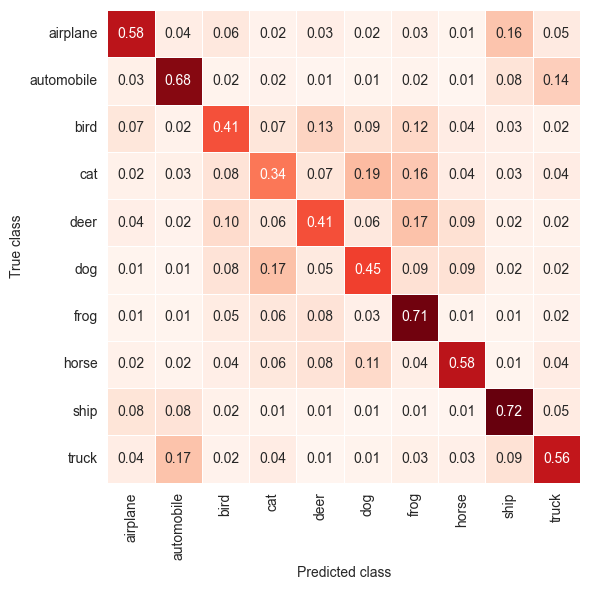

In [38]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.savefig(f'ConfusionMatrix_{test_accuracy:.3f}.png')
plt.show()

Here we focus on the diagonal and plot the numbers in a bar plot. This gives us a clearer picture of the accuracy of the model for different classes.

C:\Users\toell\OneDrive\Documents\GitHub\02456-deep-learning-with-PyTorch\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\toell\OneDrive\Documents\GitHub\02456-deep-learning-with-PyTorch\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\toell\OneDrive\Documents\GitHub\02456-deep-learning-with-PyTorch\venv\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\toell\OneDrive\Documents\GitHub\02456-deep-learning-with-PyTorch\venv\l

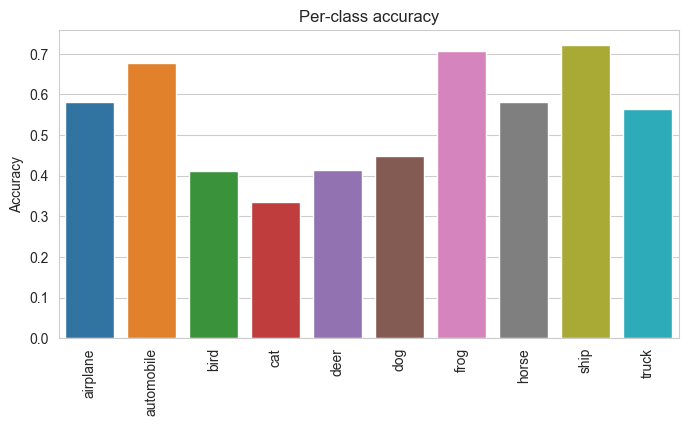

In [39]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.savefig('ConfusionMatrix.png')
    plt.show()


**Assignment 4:** 
1. Go back and improve performance of the network. By using enough convolutional layers with enough channels (and by training for long enough), you should easily be able to get a test accuracy above 60%, but see how much further you can get it! Can you reach 70%?

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?
What were the changes that seemed to improve performance the most?

3. Write down key lessons/insights you got during this exercise.

**Answer:**
By simply following the exercise guide: lots of layers and lots of training I achieved the results shown here. I did not achieve the 60 %, but I ran out of time and this is what I got.

# Training on GPU

**Optional Assignment:**
If you have a GPU, we suggest that you try training your model on GPU. For this, you need to move the model to GPU after defining it, which will recursively go over all modules and convert their parameters and buffers to CUDA tensors. You also need to transfer both the inputs and targets to GPU at each training step, before performing the forward pass.

The code for this is already in place: notice the `.to(device)` statements. The only thing left to do is change the definition of `device` from `'cpu'` to `'cuda'`.

If you don't have a GPU, you can do this on [Google Colab](https://research.google.com/colaboratory/).

Use the code below to check if any GPU is avaiable in your current setup. This should print the models of all available GPUs.


In [ ]:
# Check if we have GPUs available
print("Available CUDA devices:", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

You may not notice any significant speed-up from using a GPU. This is probably because your network is really small. Try increasing the width of your network (number of channels in the convolutional layers) and see if you observe any speed-up on GPU compared to CPU.

# Exercise from Michael Nielsen's book

**Assignment 5:** Pick an exercise of your own choice from [Michael Nielsen's book](http://neuralnetworksanddeeplearning.com/).

**Answer:**
Question: Earlier in the book we met another type of neuron known as a rectified linear unit. Explain why such neurons don't satisfy the conditions just given for universality. Find a proof of universality showing that rectified linear units are universal for computation.

Answer: Because ReLU is non-differentiable at 0 and is unbounded in the positive direction which violates the conditions for universality.
ReLU functions can, when combined, approximate an arbitrary step-function with arbitrary accuracy due to the way they can approximate a step-function when the weight is


